# Quartic potential


## Implementation of the saddle point equations
After the simplifications induced by the Nishimori identities, the system of 13 saddle point equations reduces to only 3 equations. The reduction and the equations are presented in Section "Replica saddle point equations" of the Supplementary Information.

The equations are solved by iteration.

In [ ]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as linalg
from numpy.linalg import norm 
import matplotlib.pyplot as plt
import scipy.integrate
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import pandas as pd

In [ ]:
#simple dichotomy to find zeroes of functions
def bisection(func,x_1,x_2,precision=32):
    for i in range(precision):
      m=(x_1+x_2)/2
      fm=func(m)
      if fm>0: 
        x_2=m
      else:
        x_1=m
    return (x_1+x_2)/2


#here tilde_v is already shifted by -tilde_q, so it corresponds to \tilde{V} in the paper
#H and Q are two auxiliary functions that allow to write the saddle point equations more compactly, see again "Replica saddle point equations" in the Supplementary Information.
def H(a,lam,D,tilde_v,b):
    return a*lam*(lam*D**2-D**3)-b*lam*D+tilde_v

def Q(a,lam,D,tilde_m,m,k):
    return a*m*(lam*D)**2+a*lam**2*k*D+tilde_m

#spectral density for the quartic ensemble. a and b here are \gamma and \mu respectively, hence a tunes the strength of the quartic part of the potential.
def rho(a,b,x):
    c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a)) #boundary of the spectrum
    return (b+2*a*c**2+a*x**2)*np.sqrt(4*c**2-x**2)/(2*np.pi) 

#another auxiliary function often appearing in denominators, see again "Replica saddle point equations".
def deneig(a,lam,D,b):
    return -(a*lam*(lam*D**2-D**3)-b*lam*D)

#single iterative step of the saddle point, or better fixed point, equations.
def FPiter(lam,b,m,k,opt,r):
    a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3)) #"a" is chosen such that the spectral density has unit variance
    c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a)) #boundary of the spectrum

    tilde_v=0
    FPtilde_v=lambda V: 1-m-sp.integrate.quad(lambda D: rho(a,b,D)/H(a,lam,D,V,b),-2*c,2*c)[0] #if equated to 0 yields the equation for \tilde{V} in the Supplementary Information
    tilde_v_up=0.001*rnd.uniform()+max(deneig(a,lam,2*c,b),deneig(a,lam,-2*c,b),-optimize.fminbound(lambda D: -deneig(a,lam,D,b),-2*c,2*c,full_output=True)[1])
    #tilde_v_up is chosen to be close to the right boundary of the spectrum spanned by deneig.
    tilde_v=bisection(FPtilde_v,tilde_v_up,tilde_v_up+100000000,64) 
    #the solution to the equation above grows exponentially in \lambda, that is why the left boundary of the dichotomic search is at tilde_v_up+100000000.

    tilde_m=(m-sp.integrate.quad(lambda D: rho(a,b,D)*(a*lam**2*(m*D**2+k*D))/H(a,lam,D,tilde_v,b),-2*c,2*c)[0])/(1-m) #not really needed but it allows to compactify a bit
    hat_m=m/(1-m)-tilde_m+b*lam**2*m+a*(lam**2)*sp.integrate.quad(lambda D: rho(a,b,D)*(D**2)*Q(a,lam,D,tilde_m,m,k)/H(a,lam,D,tilde_v,b),-2*c,2*c)[0]
    
    #below we offer a choice among three different priors
    #Rademacher prior
    if opt=='Rad':
      m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]
    
    #GAUSSIAN PRIOR
    if opt=="Gauss":
      m_new=hat_m/(1+hat_m)

    #sparse prior, only case in which "r" plays a role
    if opt=='sparse':
      aux=lambda X: X*sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/np.sqrt(2*np.pi)*np.sqrt(r)*np.sinh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))/(1-r+r*np.cosh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))),-15,15)[0]
      m_new=r/2*(aux(-1/np.sqrt(r))+aux(1/np.sqrt(r)))+(1-r)*aux(0)

    k_new=sp.integrate.quad(lambda D: rho(a,b,D)*D*Q(a,lam,D,tilde_m,m,k)/H(a,lam,D,tilde_v,b),-2*c,2*c)[0]

    return m_new,k_new


#concatenation of more iterative steps, see previous function
def FPrecursion(lam,b,m0,k0,conv,damp,opt='Rad',r=1.):
    m,k=m0,k0
    crit=conv+1
    it=0
    
    #we offer the possibility to damp the updates, but it proved to be unnecessary.
    while crit>conv and it<200:
        m_new,k_new=FPiter(lam,b,m,k,opt,r)
        
        crit=np.abs(m_new-m)+np.abs(k_new-k) 
        m=(1-damp)*m_new+damp*m
        k=(1-damp)*k_new+damp*k
        
        it=it+1
        if it%50==0:
          print([it,crit],'m=',m ,'k=',k ) 
    return m,k


In [ ]:
#Create b and SNR grids
bvalues=[0,.2,.5,.8]
SNR=np.linspace(.3,4,81)

#Set fixed point iterations parameters:
conv=1e-7
damp=0.0

## Standard PCA
Hereby we provide a code able to locate the spectral transition predicted by F. Benaych-Georges and R. R. Nadakuditi in arXiv:0910.2120v3, and to compute the overlap of the eigenvector corresponding to the leading eigenvalue with the ground truth.

In [ ]:

def G(z,b): # Stieltjes transform
    a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
    c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
    return 0.5* (b*z + a * z**3 - (b+2*a*c**2+a*z**2)*np.sqrt(z**2-4*c**2))

def dG(z,b): # Derivative of the Stieltjes transform
    a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
    c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
    return 0.5* (b + 3 * a * z**2 - 2 * a*z*np.sqrt(z**2-4*c**2) - (b*z+2*z*a*c**2+a*z**3)/np.sqrt(z**2-4*c**2))

def closest(x,L): # Function that finds the index that gives the closest element in L to the value x
    pot = np.abs(L-x)
    min_value = min(pot)
    return  np.where(pot == min_value)[0][0]

def K(x,b,graph_G): # Numerical approximation of the inverse of the Stieltjes transform
    i = closest(x,graph_G)
    return Z[i]

def dK(x,b,graph_G): # Derivative of the inverse of the Stieltjes transform. Expression obtained using the definition of K as the inverse of H.
    return 1/dG(K(x,b,graph_G),b)

def M_pca(lam_str,h,par,graph_G): # Value of the magnetization with signal as given in Benaych-George and Nadakuditi's paper
    value = 0
    if lam_str * h**2 > 1:
        value = - dK(1/np.sqrt(lam_str),par,graph_G) / lam_str
    return value

def PCA_opt(lam_str,h,par,graph_G): # Matrix MSE of PCA optimal (i.e., PCA estimator scaled by a multiplicative factor equal to M_pca)
    return 0.5 * ( 1 - M_pca(lam_str**2,h,par,graph_G)**2 )    


MMSE_PCA=[]


for i in range(len(bvalues)):
  b=bvalues[i]
  a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
  c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
  h=c*(b+4*a*c**2)
  variance=sp.integrate.quad(lambda D: rho(a,b,D)*D**2,-2*c,2*c)[0]
  print("a=",a,variance,'==1, second moment check')
  print('b='+str(b)+'; Exact TRANSITION AT SNR = ' + str(1/h))
  Z = np.arange(2*c+0.0001,100*c,0.0001) # Values over which I will discretize the graph of the Stieltjes transform
  graph_G = np.array([G(z,b) for z in Z]) # Discretized version of the graph of the Steiltjes transform. Used to approximate the inverse of H.

  # LIMIT OF PCA MAGNETIZATION AND MSE OF PCA OPTIMAL

  MMSE_PCA.append([ PCA_opt(x,h,b,graph_G) for x in SNR ])




a= 0.5925925925925926 0.9999999999999958 ==1, second moment check
b=0; Exact TRANSITION AT SNR = 0.6495190528383291
a= 0.46182556410959863 0.9999999999999956 ==1, second moment check
b=0.2; Exact TRANSITION AT SNR = 0.6894809223164811
a= 0.2760313731559435 0.9999999999999967 ==1, second moment check
b=0.5; Exact TRANSITION AT SNR = 0.766743575280549
a= 0.10458732231510243 1.0 ==1, second moment check
b=0.8; Exact TRANSITION AT SNR = 0.8807950162841349


## Generating data points: MMSE vs $\lambda$

In [ ]:
#Generating data points for GAUSSIAN prior
opt="Gauss"
#-----------------------------------------------------------------------------------------------
m_Gauss=[]
for b in bvalues:
  m_Gauss.append([])

for i in range(len(bvalues)):
  b=bvalues[i]
  a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
  c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
  variance=sp.integrate.quad(lambda D: rho(a,b,D)*D**2,-2*c,2*c)[0]
  print("a=",a,variance,'==1, second moment check')
  for lam in SNR:
      m0=rnd.uniform(.01,.1)
      k0=rnd.uniform(.01,.1)
      m_Gauss[i].append(FPrecursion(lam,b,m0,k0,conv,damp,opt)[0])
      print("SNR=",lam,'\t\t',"m=",m_Gauss[i][-1])
  print('\n\n')

a= 0.5925925925925926 0.9999999999999958 ==1, second moment check
SNR= 0.3 		 m= 4.874395556615378e-09
SNR= 0.34625 		 m= 4.182107858542565e-09
SNR= 0.39249999999999996 		 m= 7.244636348202103e-09
SNR= 0.43875 		 m= 1.487303692099276e-08
SNR= 0.485 		 m= 2.608886828890312e-08
SNR= 0.53125 		 m= 5.888593442706139e-08
SNR= 0.5774999999999999 		 m= 1.2503713679349544e-07
[50, 2.7455639201298947e-05] m= 0.00011548613160260784 k= 0.00013232384998981174
[100, 1.4502310220361596e-07] m= 6.098039588776309e-07 k= 6.986565951955331e-07
SNR= 0.62375 		 m= 4.004712713523772e-07
[50, 6.0694172049423345e-05] m= 0.036571562282857614 k= 0.03886331714235748
[100, 1.0357484164710828e-06] m= 0.036236554897815396 k= 0.03849879529053441
SNR= 0.6699999999999999 		 m= 0.03623123882242582
[50, 7.301248534929972e-07] m= 0.110454262175477 k= 0.11261971992225431
SNR= 0.71625 		 m= 0.11045530995717572
SNR= 0.7625 		 m= 0.17575011124370254
SNR= 0.8087500000000001 		 m= 0.23366438178314303
SNR= 0.855 		 m= 0.285396

In [ ]:
#Generating data points for Rademacher prior
opt="Rad"
#---------------------------------------------------
m_Rad=[]
for b in bvalues:
  m_Rad.append([])

for i in range(len(bvalues)):
  b=bvalues[i]
  a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
  c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
  variance=sp.integrate.quad(lambda D: rho(a,b,D)*D**2,-2*c,2*c)[0]
  print("a=",a,variance,'==1, second moment check')
  for lam in SNR:
      m0=rnd.uniform(.01,.1)
      k0=rnd.uniform(.01,.1)
      m_Rad[i].append(FPrecursion(lam,b,m0,k0,conv,damp,opt)[0])
      print("SNR=",lam,'\t\t',"m=",m_Rad[i][-1])
  print('\n\n')

a= 0.5925925925925926 0.9999999999999958 ==1, second moment check


<ipython-input-2-0eeef359889f>:48: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]


SNR= 0.3 		 m= 2.7757603591840226e-09
SNR= 0.34625 		 m= 4.450476505706108e-09
SNR= 0.39249999999999996 		 m= 5.779511711873873e-09
SNR= 0.43875 		 m= 1.9354913903973016e-08
SNR= 0.485 		 m= 1.967061816754684e-08
SNR= 0.53125 		 m= 3.84987663118281e-08
SNR= 0.5774999999999999 		 m= 1.0240809543342702e-07
[50, 3.265506575017018e-05] m= 0.00013728705428761286 k= 0.0001573054215951238
[100, 1.720816850030497e-07] m= 7.25285413652529e-07 k= 8.305891578407843e-07
SNR= 0.62375 		 m= 3.8610617058107057e-07
[50, 2.2822859211527047e-05] m= 0.03666164070588676 k= 0.03892654165383611
[100, 4.0580358061370614e-07] m= 0.036533831004942195 k= 0.038787802028150575
SNR= 0.6699999999999999 		 m= 0.036532054200307744
[50, 1.1040304157411418e-06] m= 0.1131855280158103 k= 0.1146576338270344
SNR= 0.71625 		 m= 0.11318724956853504
SNR= 0.7625 		 m= 0.18264227789154705
SNR= 0.8087500000000001 		 m= 0.2459353500521748
SNR= 0.855 		 m= 0.30394721995440516
SNR= 0.9012499999999999 		 m= 0.35739667392198143
SNR= 

##Plots

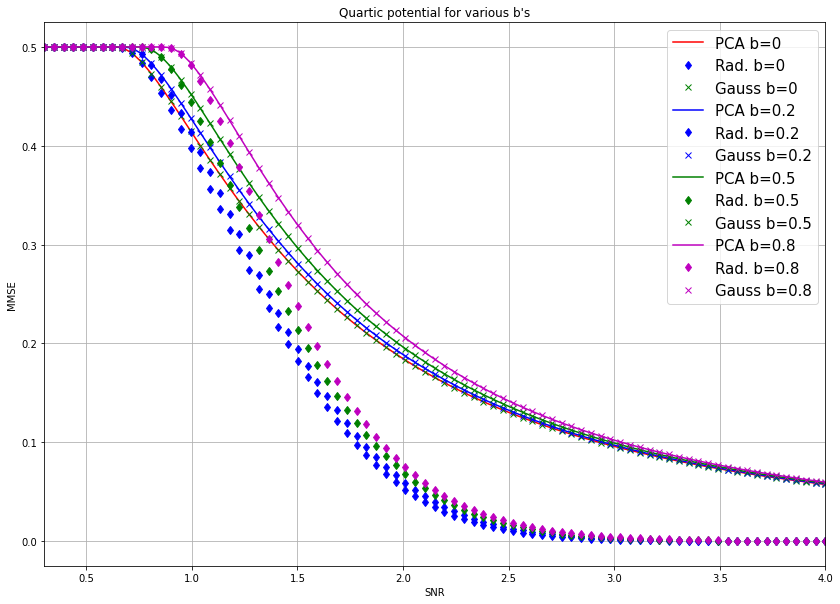

In [ ]:
#plotting and printing everything
plt.rcParams["figure.figsize"] = (14,10) # Bigger plot


plt.plot(SNR,MMSE_PCA[0],'r')
plt.plot(SNR,(1-np.square(m_Rad[0]))/2,'db')
plt.plot(SNR,(1-np.square(m_Gauss[0]))/2,'xg')

plt.plot(SNR,MMSE_PCA[1],'b')

plt.plot(SNR,(1-np.square(m_Rad[1]))/2,'db')
plt.plot(SNR,(1-np.square(m_Gauss[1]))/2,'xb')

plt.plot(SNR,MMSE_PCA[2],'g')
plt.plot(SNR,(1-np.square(m_Rad[2]))/2,'dg')
plt.plot(SNR,(1-np.square(m_Gauss[2]))/2,'xg')

plt.plot(SNR,MMSE_PCA[3],'m')
plt.plot(SNR,(1-np.square(m_Rad[3]))/2,'dm')
plt.plot(SNR,(1-np.square(m_Gauss[3]))/2,'xm')


plt.xlabel("SNR")
plt.ylabel("MMSE")
Legend=["PCA b="+str(bvalues[0]),"Rad. b="+str(bvalues[0]),"Gauss b="+str(bvalues[0]),"PCA b="+str(bvalues[1]),"Rad. b="+str(bvalues[1]),"Gauss b="+str(bvalues[1]),"PCA b="+str(bvalues[2]),"Rad. b="+str(bvalues[2]),"Gauss b="+str(bvalues[2]),"PCA b="+str(bvalues[3]),"Rad. b="+str(bvalues[3]),"Gauss b="+str(bvalues[3])]
plt.legend(Legend,fontsize=15)
plt.grid()
plt.xlim((.3,4))
plt.title("Quartic potential for various b's")
plt.show()

##What is actually doing this sub-optimal AMP? Mismatched estimation with Gaussian likelihood
We refer to the homonym Section in the Supplementary Information where we argue that the AMP algorithm designed by Opper and Winther first, and then studied by Zhou Fan https://arxiv.org/abs/2008.11892v5, is sub-optimal. In the mentioned section we find a system of 8 fixed point equations that are hereby implemented. We restrict ourselves to the Rademacher prior.

In [ ]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as linalg
from numpy.linalg import norm 
import matplotlib.pyplot as plt
import scipy.integrate
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import pandas as pd

In [ ]:
#single iterative step
def FPiter(lam,b,m,q,v,opt):
    a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
    c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))

    #1)
    tilde_v=0
    FPtilde_v=lambda V: v-q-sp.integrate.quad(lambda D: rho(a,b,D)/(V-lam*D),-2*c,2*c)[0]
    tilde_v=bisection(FPtilde_v,2*c*lam+1e-5,2*c*lam+100000,64)
    
    #2)
    hat_V=lam**2*v+1/(v-q)-tilde_v
    #3)
    tilde_q=q/sp.integrate.quad(lambda D: rho(a,b,D)/((tilde_v-lam*D)**2),-2*c,2*c)[0]
    #4)
    hat_q=q/(v-q)**2-tilde_q #here the (v-q)**2 at the denominator is very problematic for high SNR. Indeed when \lambda>3 q is around 0.999, and v-q is roughly 0.001. This causes numerical instability.
    #5)
    hat_m=lam**2*m

    if opt=='Rad':
      #6)
      m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_q)+hat_m),-18,18)[0]
      #7)
      q_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_q)+hat_m)**2,-18,18)[0]
      #8)
      v_new=1

    return m_new,q_new,v_new


#concatenation of iterative steps, see function above
def FPrecursion(lam,b,m0,q0,v0,conv,damp,opt='Rad'):
    m,q,v=m0,q0,v0
    crit=conv+1
    it=0

    while crit>conv and it<800:
        m_new,q_new,v_new=FPiter(lam,b,m,q,v,opt)
        crit=np.abs(m_new-m)+np.abs(q_new-q) +np.abs(v_new-v)
        m=(1-damp)*m_new+damp*m
        q=(1-damp)*q_new+damp*q
        v=(1-damp)*v_new+damp*v
        
        it=it+1
        if it%60==0:
          print([it,crit],'m=',m ,'q=',q,'v=',v ) 
    return m,q,v

In [ ]:
#Create b, SNR grid
bvalues=[0.]
SNR=np.arange(3.08,4.04,0.06)

#Set fixed point iterations parameters:
conv=1e-7
#here the damping proved to stabilize a bit
damp=0.7

In [ ]:
#Generating data points for Rademacher prior
opt="Rad"
#------------------------------------------------------------------------
mm_Rad=[]
qq_Rad=[]
for b in bvalues:
  mm_Rad.append([])
  qq_Rad.append([])

for i in range(len(bvalues)):
  b=bvalues[i]
  a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
  c=np.sqrt((np.sqrt(b**2+12*a)-b)/(6*a))
  variance=sp.integrate.quad(lambda D: rho(a,b,D)*D**2,-2*c,2*c)[0]
  print("a=",a,variance,'==1, second moment check')
  for lam in SNR:
      m0=rnd.uniform(.9,.99)
      q0=rnd.uniform(.9,.99)
      v0=1
      XX=FPrecursion(lam,b,m0,q0,v0,conv,damp,opt)
      mm_Rad[i].append(XX[0])
      qq_Rad[i].append(XX[1])
      print("SNR=",lam,'\t\t',"m=",mm_Rad[i][-1],'q=',qq_Rad[i][-1],'MSE=',.5*(1-2*mm_Rad[i][-1]**2+qq_Rad[i][-1]**2))
  print('\n\n')

#writing on txt files,
for k in range(len(bvalues)):
  b=bvalues[k]
  a=1/27*(8-9*b+np.sqrt(64-144*b+108*b**2-27*b**3))
  f=open("mismatch_quartic_potential_b="+str(b)+"damped.txt",'w+')
  f.write('RADEMACHER PRIOR\n')
  f.write('(a='+str(a)+', b='+str(b)+')\n\n')
  f.write("{:^10}".format('SNR')+"{:^10}".format('mag')+"{:^10}".format('ov')+"{:^10}".format('MSE')+'\n')
  
  for i in np.arange(len(SNR)):
    f.write("{:10.7f}".format(SNR[i])+"{:10.7f}".format(mm_Rad[k][i])+"{:10.7f}".format(qq_Rad[k][i])+"{:10.7f}".format((1-2*mm_Rad[k][i]**2+qq_Rad[k][i]**2)/2)+'\n')
  f.close()


#Power six potential

##Saddle point equations

In [ ]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as linalg
from numpy.linalg import norm 
import matplotlib.pyplot as plt
import scipy.integrate
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import pandas as pd

In [ ]:
#simple dichotomy to find zeroes of functions
def bisection(func,x_1,x_2,precision=32):
    for i in range(precision):
      m=(x_1+x_2)/2
      fm=func(m)
      if fm>0: 
        x_2=m
      else:
        x_1=m
    return (x_1+x_2)/2


#here tilde_v is already shifted by -tilde_q, so it corresponds to \tilde{V} in the paper
#H and Q are two auxiliary functions that allow to write the saddle point equations more compactly, see again "Replica saddle point equations" in the Supplementary Information.
def H(xi,lam,D,tilde_v):
    return tilde_v-xi*lam*D**5 +xi*lam**2*D**4+xi*lam**2*D**2

def Q(xi,lam,D,tilde_m,m,k1,k2,k3):
    return xi*lam**2*(m*D**4+k1*D**3+k2*D**2+k3*D)-tilde_m

#spectral density for the pure power six ensemble.
def rho(xi,x):
    a=(1/(10*xi))**(1/6) #boundary of the spectrum
    return (6*a**4*xi+2*a**2*x**2*xi+xi*x**4)*np.sqrt(4*a**2-x**2)/(2*np.pi) 

#another auxiliary function often appearing in denominators, see again "Replica saddle point equations".
def deneig(xi,lam,D):
    return -(-xi*lam*D**5 +xi*lam**2*D**4+xi*lam**2*D**2)

#single iterative step of the saddle point, or better fixed point, equations.
def FPiter(lam,xi,m,k1,k2,k3,opt,r):
    a=(1/(10*xi))**(1/6) #boundary of the spectrum

    tilde_v=0
    FPtilde_v=lambda V: 1-m-sp.integrate.quad(lambda D: rho(xi,D)/H(xi,lam,D,V),-2*a,2*a)[0] #if equated to 0 yields the equation for \tilde{V} in the Supplementary Information
    tilde_v_up=0.0001*rnd.uniform()+max(deneig(xi,lam,2*a),deneig(xi,lam,-2*a),-optimize.fminbound(lambda D: -deneig(xi,lam,D),-2*a,2*a,full_output=True)[1])
    #tilde_v_up is chosen to be close to the right boundary of the spectrum spanned by deneig.
    tilde_v=bisection(FPtilde_v,tilde_v_up,tilde_v_up+100000000,64) 
    #the solution to the equation above grows exponentially in \lambda, that is why the left boundary of the dichotomic search is at tilde_v_up+100000000.

    tilde_m=(sp.integrate.quad(lambda D: rho(xi,D)*xi*lam**2*(m*D**4+k1*D**3+k2*D**2+k3*D)/H(xi,lam,D,tilde_v),-2*a,2*a)[0]-m)/(1-m) #not really needed but it allows to compactify a bit
    hat_m=m/(1-m)+tilde_m+xi*(lam**2)*sp.integrate.quad(lambda D: rho(xi,D)*(D**4)*Q(xi,lam,D,tilde_m,m,k1,k2,k3)/H(xi,lam,D,tilde_v),-2*a,2*a)[0]
    
    #below we offer a choice among three different priors
    #Rademacher prior
    if opt=='Rad':
      m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]
    
    #GAUSSIAN PRIOR
    if opt=="Gauss":
      m_new=hat_m/(1+hat_m)

    #sparse prior, only case in which "r" plays a role
    if opt=='sparse':
      aux=lambda X: X*sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/np.sqrt(2*np.pi)*np.sqrt(r)*np.sinh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))/(1-r+r*np.cosh((Z*np.sqrt(hat_m)+hat_m*X)/np.sqrt(r))*np.exp(-hat_m/(2*r))),-15,15)[0]
      m_new=r/2*(aux(-1/np.sqrt(r))+aux(1/np.sqrt(r)))+(1-r)*aux(0)

    k1_new=sp.integrate.quad(lambda D: rho(xi,D)*D**1*Q(xi,lam,D,tilde_m,m,k1,k2,k3)/H(xi,lam,D,tilde_v),-2*a,2*a)[0]
    k2_new=sp.integrate.quad(lambda D: rho(xi,D)*D**2*Q(xi,lam,D,tilde_m,m,k1,k2,k3)/H(xi,lam,D,tilde_v),-2*a,2*a)[0]
    k3_new=sp.integrate.quad(lambda D: rho(xi,D)*D**3*Q(xi,lam,D,tilde_m,m,k1,k2,k3)/H(xi,lam,D,tilde_v),-2*a,2*a)[0]

    return m_new,k1_new,k2_new,k3_new


#concatenation of more iterative steps, see previous function
def FPrecursion(lam,xi,m0,k10,k20,k30,conv,damp,opt='Rad',r=1.):
    m,k1,k2,k3=m0,k10,k20,k30
    crit=conv+1
    it=0
    
    #we offer the possibility to damp the updates, but it proved to be unnecessary.
    while crit>conv and it<200:
        m_new,k1_new,k2_new,k3_new=FPiter(lam,xi,m,k1,k2,k3,opt,r)
        
        crit=np.abs(m_new-m)+np.abs(k1_new-k1) +np.abs(k2_new-k2) +np.abs(k3_new-k3) 
        m=(1-damp)*m_new+damp*m
        k1=(1-damp)*k1_new+damp*k1
        k2=(1-damp)*k2_new+damp*k2
        k3=(1-damp)*k3_new+damp*k3
        
        it=it+1
        if it%50==0:
          print([it,crit],'m=',m ,'k1=',k1 ,'k2=',k2 ,'k3=',k3) 
    return m,k1,k2,k3


In [ ]:
xi=27./80.
#a=1/(10*xi)**(1/6)
a=np.sqrt(2./3.)

SNR=np.arange(.5,1.01,0.02)

#Set fixed point iterations parameters:
conv=1e-7
damp=0.0

variance=sp.integrate.quad(lambda D: rho(xi,D)*D**2,-2*a,2*a)[0]
print("xi=",xi,variance,'==1, second moment check')
print(SNR)

xi= 0.3375 0.9999999999999822 ==1, second moment check
[0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76
 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [ ]:
#Generating data points for Rademacher prior
opt="Rad"
#---------------------------------------------------
m_Rad=np.zeros(len(SNR))
k1_Rad=np.zeros(len(SNR))
k2_Rad=np.zeros(len(SNR))
k3_Rad=np.zeros(len(SNR))



for i in range(len(SNR)):
    lam=SNR[i]
    m0=rnd.uniform(.01,.1)
    k10=rnd.uniform(.01,.1)
    k20=rnd.uniform(.01,.1)
    k30=rnd.uniform(.01,.1)
    m_Rad[i],k1_Rad[i],k2_Rad[i],k3_Rad[i]=FPrecursion(lam,xi,m0,k10,k20,k30,conv,damp,opt='Rad')
    print("SNR=",lam,'\t\t',"m=",m_Rad[i],'MSE=',(1-m_Rad[i]**2)/2,'k1=',k1_Rad[i] ,'k2=',k2_Rad[i] ,'k3=',k3_Rad[i])
print('\n\n')

<ipython-input-7-79aab6aeee76>:47: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  m_new=sp.integrate.quad(lambda Z: np.exp(-Z**2/2)/sp.sqrt(2*np.pi)*np.tanh(Z*np.sqrt(hat_m)+hat_m),-15,15)[0]


[50, 0.0004791175290574474] m= 0.0013270714707034083 k1= 0.001525194923219469 k2= 0.00251289682174124 k3= 0.003352577533985167
[100, 3.475732180993781e-05] m= 0.00010284750163185346 k1= 0.00011810702839752257 k2= 0.00019447496735860396 k3= 0.00025981101536296853
[150, 2.830069817505918e-06] m= 8.442818225587783e-06 k1= 9.689182553585346e-06 k2= 1.5953798178764715e-05 k3= 2.131571993059874e-05
[200, 2.3416906286300484e-07] m= 7.118009881297734e-07 k1= 8.174062130521909e-07 k2= 1.3453112368358927e-06 k3= 1.7981959868458448e-06
SNR= 0.5 		 m= 7.118009881297734e-07 MSE= 0.49999999999974665 k1= 8.174062130521909e-07 k2= 1.3453112368358927e-06 k3= 1.7981959868458448e-06
[50, 0.00030340550120599996] m= 0.018001410673912536 k1= 0.020046773499170584 k2= 0.03275485106363897 k3= 0.04407057894015699
[100, 2.8213363125386554e-05] m= 0.01713773937696851 k1= 0.019073893605859128 k2= 0.0311523480808439 k3= 0.04195475036924948
[150, 2.8686709768813157e-06] m= 0.017053619239760863 k1= 0.0189791910771291

KeyboardInterrupt: ignored

In [ ]:
#save into a file

f=open("sestic_Rad_replica.txt",'w+')
f.write("{:<10}".format('SNR')+"{:<10}".format('MMSE')+"{:<10}".format('m')+"{:<10}".format('k1')+"{:<10}".format('k2')+"{:<2}".format('k3\n'))
for i in np.arange(len(SNR)):
  f.write("{:<10.7f}".format(SNR[i])+"{:<10.7f}".format((1-m_Rad[i]**2)/2)+"{:<10.7f}".format(m_Rad[i])+"{:<10.7f}".format(k1_Rad[i])+"{:<10.7f}".format(k2_Rad[i])+"{:<10.7f}".format(k3_Rad[i])+'\n')
f.close()

In [ ]:
#Generating data points for Rademacher prior
opt="sparse"
r=.2
#---------------------------------------------------
m_sparse=np.zeros(len(SNR))
k1_sparse=np.zeros(len(SNR))
k2_sparse=np.zeros(len(SNR))
k3_sparse=np.zeros(len(SNR))



for i in range(len(SNR)):
    lam=SNR[i]
    m0=rnd.uniform(.01,.1)
    k10=rnd.uniform(.01,.1)
    k20=rnd.uniform(.01,.1)
    k30=rnd.uniform(.01,.1)
    m_sparse[i],k1_sparse[i],k2_sparse[i],k3_sparse[i]=FPrecursion(lam,xi,m0,k10,k20,k30,conv,damp,opt,r)
    print("SNR=",lam,'\t\t',"m=",m_sparse[i],'MSE=',(1-m_sparse[i]**2)/2,'k1=',k1_sparse[i] ,'k2=',k2_sparse[i] ,'k3=',k3_sparse[i])
print('\n\n')

In [ ]:
#save sestic sparse in file .txt

f=open("sestic_sparse_replica.txt",'w+')
f.write('r='+str(r)+'\n')
f.write("{:<10}".format('SNR')+"{:<10}".format('MMSE')+"{:<10}".format('m')+"{:<10}".format('k1')+"{:<10}".format('k2')+"{:<2}".format('k3\n'))
for i in np.arange(len(SNR)):
  f.write("{:<10.7f}".format(SNR[i])+"{:<10.7f}".format((1-m_sparse[i]**2)/2)+"{:<10.7f}".format(m_sparse[i])+"{:<10.7f}".format(k1_sparse[i])+"{:<10.7f}".format(k2_sparse[i])+"{:<10.7f}".format(k3_sparse[i])+'\n')
f.close()

In [ ]:
#Generating data points for Rademacher prior
opt="Gauss"
#---------------------------------------------------
m_Gauss=np.zeros(len(SNR))
k1_Gauss=np.zeros(len(SNR))
k2_Gauss=np.zeros(len(SNR))
k3_Gauss=np.zeros(len(SNR))



for i in range(len(SNR)):
    lam=SNR[i]
    m0=rnd.uniform(.01,.1)
    k10=rnd.uniform(.01,.1)
    k20=rnd.uniform(.01,.1)
    k30=rnd.uniform(.01,.1)
    m_Gauss[i],k1_Gauss[i],k2_Gauss[i],k3_Gauss[i]=FPrecursion(lam,xi,m0,k10,k20,k30,conv,damp,opt,r=1)
    print("SNR=",lam,'\t\t',"m=",m_Gauss[i],'MSE=',(1-m_Gauss[i]**2)/2,'k1=',k1_Gauss[i] ,'k2=',k2_Gauss[i] ,'k3=',k3_Gauss[i])
print('\n\n')

[50, 0.0004578087287796268] m= 0.0012717181117250361 k1= 0.0014615266744281306 k2= 0.0024079309627837177 k3= 0.003212736058657057
[100, 3.338318177016823e-05] m= 9.880356561141893e-05 k1= 0.00011346280503226727 k2= 0.00018682742216308176 k3= 0.000249595308247422
[150, 2.719269969056788e-06] m= 8.112430925366176e-06 k1= 9.310019072495533e-06 k2= 1.5329481275185268e-05 k3= 2.0481583234120358e-05
[200, 2.2551676952586003e-07] m= 6.845309390749447e-07 k1= 7.861021941560421e-07 k2= 1.2937424393231214e-06 k3= 1.7293163508382167e-06
SNR= 0.5 		 m= 6.845309390749447e-07 MSE= 0.4999999999997657 k1= 7.861021941560421e-07 k2= 1.2937424393231214e-06 k3= 1.7293163508382167e-06
[50, 0.00027105058000085475] m= 0.017861685694862406 k1= 0.019893264481224523 k2= 0.03250040309941646 k3= 0.043736677121204666
[100, 2.5322337043175852e-05] m= 0.017087848959563685 k1= 0.01902118720532114 k2= 0.031064272081615572 k3= 0.04183988257858459
[150, 2.56446417047293e-06] m= 0.017012464105143933 k1= 0.018936278042984